<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-12-21 03:44:49--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-12-21 03:44:49 (240 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()
# df.loc[df['loan_status'] == "COLLECTION"]

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()
# df.head()
# df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
# df.head()
# 0: collecting 
# 1: paid off 

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



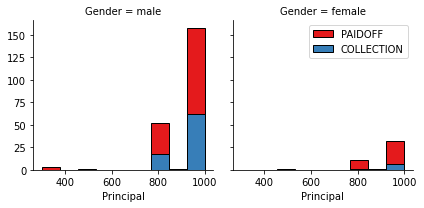

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

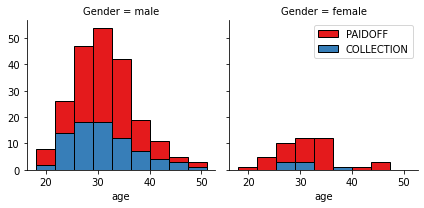

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


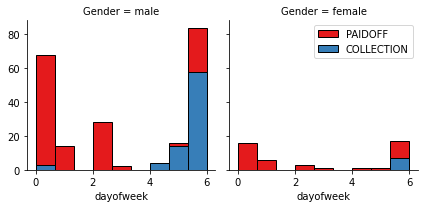

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              1              0.750000
                      0              0.250000
High School or Below  1              0.741722
                      0              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               1              0.765101
                      0              0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# Creating Training and Testing data

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
from sklearn.neighbors import KNeighborsClassifier
# number of neighbors (k)
k = 4
neighbors = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
yhat = neighbors.predict(X_test)

from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neighbors.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8514492753623188
Test set Accuracy:  0.6857142857142857


In [22]:
K_max = 35
mean_acc = np.zeros((K_max - 1))
std_acc = np.zeros((K_max - 1))

for n in range(1, K_max):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


for idx, val in enumerate(mean_acc):
    print(f"{idx} {val} {val == 0.7}")
print(max(mean_acc))

0 0.6 False
1 0.6428571428571429 False
2 0.6714285714285714 False
3 0.6857142857142857 False
4 0.6428571428571429 False
5 0.6428571428571429 False
6 0.6571428571428571 False
7 0.6571428571428571 False
8 0.6428571428571429 False
9 0.6714285714285714 False
10 0.6714285714285714 False
11 0.6857142857142857 False
12 0.6571428571428571 False
13 0.6571428571428571 False
14 0.6714285714285714 False
15 0.6714285714285714 False
16 0.6428571428571429 False
17 0.6428571428571429 False
18 0.6428571428571429 False
19 0.6428571428571429 False
20 0.6428571428571429 False
21 0.6571428571428571 False
22 0.6285714285714286 False
23 0.6714285714285714 False
24 0.6285714285714286 False
25 0.6714285714285714 False
26 0.6857142857142857 False
27 0.7 True
28 0.6857142857142857 False
29 0.6857142857142857 False
30 0.6857142857142857 False
31 0.6857142857142857 False
32 0.6857142857142857 False
33 0.6857142857142857 False
0.7


In [23]:
k = 27
neighbors = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
yhat = neighbors.predict(X_test)

# Decision Tree


In [24]:
from sklearn.tree import DecisionTreeClassifier
dT = DecisionTreeClassifier(criterion="gini", max_depth = None)
dT.fit(X_train,y_train)
predTree = dT.predict(X_test)

In [25]:
from sklearn import metrics
print(f"DecisionTrees's Accuracy at depth adaptive {metrics.accuracy_score(y_test, predTree)}")

max_depth = 25
for depth in range(1, max_depth):
    dT = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    dT.fit(X_train,y_train)
    predTree = dT.predict(X_test)
    print(f"DecisionTrees's Accuracy at depth {depth} {metrics.accuracy_score(y_test, predTree)}")

DecisionTrees's Accuracy at depth adaptive 0.5714285714285714
DecisionTrees's Accuracy at depth 1 0.6714285714285714
DecisionTrees's Accuracy at depth 2 0.6714285714285714
DecisionTrees's Accuracy at depth 3 0.6714285714285714
DecisionTrees's Accuracy at depth 4 0.5857142857142857
DecisionTrees's Accuracy at depth 5 0.6142857142857143
DecisionTrees's Accuracy at depth 6 0.5571428571428572
DecisionTrees's Accuracy at depth 7 0.5714285714285714
DecisionTrees's Accuracy at depth 8 0.5857142857142857
DecisionTrees's Accuracy at depth 9 0.6
DecisionTrees's Accuracy at depth 10 0.5857142857142857
DecisionTrees's Accuracy at depth 11 0.5571428571428572
DecisionTrees's Accuracy at depth 12 0.5857142857142857
DecisionTrees's Accuracy at depth 13 0.5714285714285714
DecisionTrees's Accuracy at depth 14 0.5714285714285714
DecisionTrees's Accuracy at depth 15 0.5714285714285714
DecisionTrees's Accuracy at depth 16 0.5714285714285714
DecisionTrees's Accuracy at depth 17 0.5714285714285714
DecisionTr

In [26]:
dT = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
dT.fit(X_train,y_train)
predTree = dT.predict(X_test)

# Support Vector Machine


In [28]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

svm_yhat = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.57      0.17      0.27        23
           1       0.70      0.94      0.80        47

    accuracy                           0.69        70
   macro avg       0.63      0.56      0.53        70
weighted avg       0.66      0.69      0.62        70

[[ 4 19]
 [ 3 44]]


0.6714285714285714

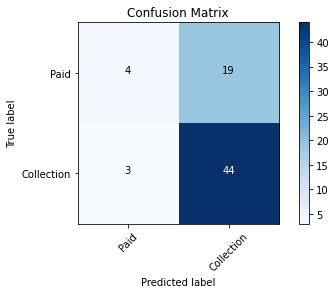

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid','Collection'])

from sklearn.metrics import jaccard_score
jaccard_score(y_test, svm_yhat, pos_label=1)

# Logistic Regression


sag 0.0
saga 0.0
liblinear 0.0
[[ 0 23]
 [ 0 47]]


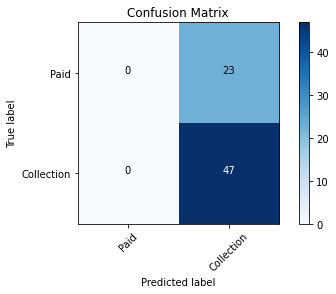

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def printModel(C_val, model):
    logReg = LogisticRegression(C=C_val, solver=model).fit(X_train, y_train)
    yhat = logReg.predict(X_test)
    print(model, jaccard_score(y_test, yhat,pos_label=0))

printModel(.1, "sag")
printModel(.1, "saga")
printModel(.1, "liblinear")

logReg = LogisticRegression(C=0.1, solver="liblinear").fit(X_train, y_train)
yhat = logReg.predict(X_test)

cnf_matrix = confusion_matrix(y_test, yhat)
plot_confusion_matrix(cnf_matrix, classes=['Paid','Collection'])

# Model Evaluation using Test set


In [42]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [43]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-12-21 03:47:15--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-12-21 03:47:15 (76.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [44]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X = Feature 
X = preprocessing.StandardScaler().fit(X).transform(X)

y = df['loan_status'].values

In [45]:
# KNN Reporting
# Jaccard, F1 
KNN_vars = [0, 0]
KNN_yhat = neighbors.predict(X)
KNN_vars[0] = metrics.accuracy_score(y, KNN_yhat)
KNN_vars[1] = f1_score(y, KNN_yhat, average='weighted') 

In [46]:
# Descion Tree reporting 
# Jaccard, F1 
dt_vars = [0, 0]
dt_yhat = dT.predict(X)
dt_vars[0] = metrics.accuracy_score(y, dt_yhat)
dt_vars[1] = f1_score(y, dt_yhat, average='weighted') 

In [47]:
# SVM Reporting
# Jaccard, F1 
SVM_vars = [0, 0]
SVM_yhat = clf.predict(X)
SVM_vars[0] = metrics.accuracy_score(y, SVM_yhat)
SVM_vars[1] = f1_score(y, SVM_yhat, average='weighted') 

In [72]:
# Logistic Reg reporting 
# Jaccard, F1 , LogLoss 
logReg = LogisticRegression(C=0.5, solver="saga").fit(X_train, y_train)

log_vars = [0, 0, 0]
log_yhat = logReg.predict(X)
log_vars[0] = metrics.accuracy_score(y, log_yhat)
log_vars[1] = f1_score(y, log_yhat, average='weighted') 
log_vars[2] = log_loss(y, log_yhat)

In [73]:
reporting = [['KNN', KNN_vars[0], KNN_vars[1], "NA"], 
             ['Decision Tree', dt_vars[0], dt_vars[1], "NA"], 
             ['SVM', SVM_vars[0], SVM_vars[1], "NA"],
             ['LogisticRegression', log_vars[0], log_vars[1], log_vars[2]]]
output_df = pd.DataFrame(reporting, columns = ['Algorithim', 'Jaccard', 'F1-score', 'LogLoss'])

# output_df.style.hide_index()
output_df

,Algorithim,Jaccard,F1-score,LogLoss
0,KNN,0.736994,0.695931,NA
1,Decision Tree,0.829480,0.834267,NA
2,SVM,0.754335,0.651584,NA
3,LogisticRegression,0.742775,0.655119,8.884444


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
